# Importing Basic Libraries

In [1]:
import scipy.io
import scipy.signal
import librosa
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import random
from datetime import datetime
import numpy as np
import torch.nn as nn


# Importing the HFA Data and Pairing it with Spectrogram

In [2]:
NUM_PATIENTS = 29
patient_data = []


spectrogram_mat = scipy.io.loadmat("../pink-floyd-data/thewall1_stim128.mat")
spectrogram_128 = spectrogram_mat['stim128']

class HFA_MAT:
    def __init__(self, mat, coords_mat):
        self.artifacts = mat['artifacts']
        self.electrode_locations = coords_mat['elec_mni_frvr']['elecpos'][0][0]
        self.ecog = mat['ecog']
        self.dataInfo = mat['dataInfo']
        self.shape = self.ecog.shape
        self.spectrogram = spectrogram_128

    def remove_artifact_electrodes(self, ecog, artifacts):
        indices = []
        if(np.sum(artifacts) == 0):
            return ecog
        for i in range(artifacts.shape[1]):
            for j in range(artifacts.shape[0]):
                if(artifacts[j][i] == 1):
                    indices.append(i)

        return np.delete(ecog, indices, 1)

for i in range(NUM_PATIENTS):
    mat = scipy.io.loadmat(f"../pink-floyd-data/P{i+1}_HFA_data.mat")
    coords_mat = scipy.io.loadmat(f"../pink-floyd-data/P{i+1}_MNI_electrode_coordinates.mat")
    hfa = HFA_MAT(mat, coords_mat)
    patient_data.append(hfa)

# Split HFA Data and Stimulus into Random Subsections

In [3]:
fs = 100
num_rows_total = patient_data[0].shape[0]


electrode_positions = {
    'superior_temporal_gyrus': [-59, -24, 1],
    'middle_temporal_gyrus': [-59, -29, -3],
    'inferior_frontal_gyrus':[45, 48, -2],
}

class PFDataset(Dataset):
    def __init__(self, full_patient_data,segment_length_seconds, channels_crop=40, spectrogram_transform=True):
        self.ecog_segments = []
        self.stim_labels = []
        self.segment_idxs = []
        self.ecog_spectrogram_segments = []
        self.spectrogram_transform = spectrogram_transform
        self.full_patient_data = full_patient_data
        self.channels_crop = channels_crop
        self.patient_ids = []
        self.electrode_locations = []
        self.location_categories = []
        self.segment_length_seconds = segment_length_seconds
        if(self.spectrogram_transform):
            self.create_spectrogram_data()
        else:
            self.create_data()
    def __len__(self):
        return len(self.stim_labels)

    def create_data(self):
        for pat_id, data in enumerate(self.full_patient_data):
            for i in range(int(np.floor(num_rows_total / (self.segment_length_seconds * fs)))):
                random_channels_start = int((data.shape[1] - self.channels_crop) * random.random())
                start_idx = int(i * self.segment_length_seconds * fs)
                end_idx = start_idx + int(self.segment_length_seconds * fs)
                ecog_segment = data.ecog[start_idx:end_idx, random_channels_start:random_channels_start + self.channels_crop]
                self.electrode_locations.append(data.electrode_locations[random_channels_start:random_channels_start + self.channels_crop, :])
                stim_segment = data.spectrogram[start_idx:end_idx, :]
                self.ecog_segments.append(ecog_segment)
                self.patient_ids.append(pat_id)
                self.stim_labels.append(stim_segment)
                self.segment_idxs.append([start_idx, end_idx])

    def create_spectrogram_data(self):
        for pat_id, data in enumerate(self.full_patient_data):
            full_spectrograms, location_categories = self.input_spectrogram_transform(data.ecog, data.electrode_locations)
            if(len(location_categories) > 0):
                for i in range(num_rows_total // int(self.segment_length_seconds * fs)):
                    start_idx = int(i * self.segment_length_seconds * fs)
                    end_idx = start_idx + int(self.segment_length_seconds * fs)
                    ecog_segment = data.ecog[start_idx:end_idx, :]
                    ecog_spectrogram_segment = full_spectrograms[:, start_idx:end_idx, 0]
                    stim_segment = data.spectrogram[start_idx:end_idx, :]
                    if(ecog_spectrogram_segment.shape[0] == 200 and ecog_spectrogram_segment.shape[1] == 150):
                        print(ecog_spectrogram_segment.shape)
                        self.patient_ids.append(pat_id)
                        self.ecog_segments.append(ecog_segment)
                        self.stim_labels.append(stim_segment)
                        self.location_categories.append(location_categories)
                        self.segment_idxs.append([start_idx, end_idx])
                        self.ecog_spectrogram_segments.append(ecog_spectrogram_segment)


    def get_data_shape(self):
        return self.__getitem__(0)[0][0].shape

    def get_label_shape(self):
        return self.stim_labels[0].shape

    def input_spectrogram_transform(self, ecog_data, electrode_locations):
        num_bins = 200
        num_timesteps = ecog_data.shape[0]
        f_min = 0
        f_max = 50

        geographical_electrodes, location_categories = self.get_geographical_electrodes(electrode_locations)
        transformed_ecog = np.zeros([num_bins, num_timesteps, len(geographical_electrodes.keys())])
        
        for _, electrode_idxs in geographical_electrodes.items():
            k, i = 0, 0
            electrodes_composed = np.zeros([ecog_data.shape[0], len(electrode_idxs)])
            for idx in electrode_idxs:
                electrodes_composed[:, i] += ecog_data[:, idx]
                i += 1
            spectrogram_per_localization = np.zeros([num_bins, num_timesteps])
            for j in range(electrodes_composed.shape[1]):
                mel_spec = librosa.feature.melspectrogram(y=electrodes_composed[:, j], sr=fs, hop_length=(electrodes_composed.shape[0]//num_timesteps),
                  n_fft=250, n_mels=num_bins, fmin=f_min, fmax=f_max, win_length=num_bins)
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:num_bins,:num_timesteps]
                spectrogram_per_localization += mel_spec_db
                spectrogram_per_localization /= electrodes_composed.shape[1]
                
            
            transformed_ecog[:, :, k] += spectrogram_per_localization
            k += 1
        return transformed_ecog, location_categories


    def get_geographical_electrodes(self, electrode_locations):
        res = {
            'superior_temporal_gyrus': [],
            'middle_temporal_gyrus': [],
            'inferior_frontal_gyrus': [],
        }
        for i in range(electrode_locations.shape[0]):
            for electrode_name, electrode_position in electrode_positions.items():
                dist = np.linalg.norm(np.array(electrode_locations[i]) - np.array(electrode_position))
                if (dist < 30):
                    res[electrode_name].append(i)
        

        arr = []
        for electrode_name, electrode_idxs in res.items():
            if(len(electrode_idxs)>0):
                arr.append(electrode_name)
        
        return res, arr

    def __getitem__(self, index):
        ecog = None
        patient_id = self.patient_ids[index]
        location_categories = None
        if(self.spectrogram_transform):
            ecog = self.ecog_spectrogram_segments[index]
            location_categories = self.location_categories[index]
        else:
            ecog = self.ecog_segments[index]
        stim = self.stim_labels[index]
        segment_idx = self.segment_idxs[index]
        return (ecog, location_categories, segment_idx, patient_id), stim



# Initialize PF Dataset With Dataset Hyperparameters


In [4]:
# Can be varied to create different types of datasets, depending on how long of song you are trying to reconstruct (Hyperparameter)
SEGMENT_LENGTH = 1.5 #(seconds)

pf_dataset = PFDataset(patient_data, SEGMENT_LENGTH)


(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)
(200, 150)

# Test Plot of Datapoint

[('inferior_frontal_gyrus',)]


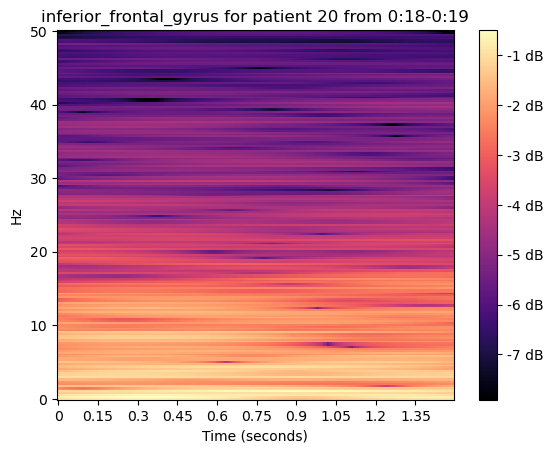

In [5]:
(sample_datapoint, location_categories, segment_idx, patient_id), sample_stim = next(iter(DataLoader(pf_dataset, shuffle=True)))
print(location_categories)
sample_datapoint = sample_datapoint.view(200,150)
sample_stim = sample_stim.view(150, 128)
fig, ax = plt.subplots()
img = librosa.display.specshow(np.array(sample_datapoint[:, :]), sr=100, x_axis="s", y_axis="linear", hop_length=1, fmin=0, fmax=50)
ax.set(title=f'{location_categories[0][0]} for patient {patient_id.item() + 1} from {(segment_idx[0].item() // 100) // 60}:{((segment_idx[0].item() // 100) % 60)}-{(segment_idx[1].item() // 100) // 60}:{((segment_idx[1].item() // 100) % 60)}')
plt.colorbar(img, ax=ax, format="%+2.f dB")
plt.savefig(f'../figures/P{patient_id.item() + 1}_{(segment_idx[0].item() // 100) // 60}:{((segment_idx[0].item() // 100) % 60)}-{(segment_idx[1].item() // 100) // 60}:{((segment_idx[1].item() // 100) % 60)}_{location_categories[0][0]}.png')


# Variational Auto-Encoder for Representation Learning

In [6]:
class UnFlatten(nn.Module):
    def __init__(self, output_shape):
        super(UnFlatten, self).__init__()
        self.output_shape = output_shape
    def forward(self, x):
        return x.view(x.shape[0], *self.output_shape)


class VariationalAutoEncoder(nn.Module):
    # input_shape and output_shape should be the same for lossless encoding and decoding
    # h_dim is the shape of the flattened-data after going through the encoder
    # regression_output_shape is the shape of the output of the regression model mapping the latent representation to the audio
    def __init__(self, input_shape, output_shape, regression_output_shape, h_dim=324):
        super(VariationalAutoEncoder, self).__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.h_dim = h_dim
        self.regression_output_shape = regression_output_shape

        # setting the latent dimension to the time segment that the network is trained on
        self.latent_dim = input_shape[1]

        # encoder which will give the latent-representation of the EEG data
        self.encoder = nn.Sequential(
            nn.Conv2d(self.input_shape[-1], 32, 4),
            nn.ReLU(),
            nn.Conv2d(32, 16, 4),
            nn.ReLU(),
            nn.Conv2d(16, 8, 4),
            nn.ReLU(),
            nn.Conv2d(8, 4, 4),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Flatten(),
        )
         # latent mean and variance
        self.mean_layer = nn.Linear(self.h_dim, self.latent_dim)
        self.logvar_layer = nn.Linear(self.h_dim, self.latent_dim)

        self.unflatten = nn.Sequential(
            nn.Linear(self.latent_dim, torch.prod(torch.tensor(self.output_shape))),
            nn.ReLU(),
            UnFlatten(self.output_shape),

        )
        # decoder which will return the original EEG data
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 8, 4),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, 4),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, 4),
            nn.ReLU(),
            nn.ConvTranspose2d(32, self.input_shape[-1], 4),
            nn.Flatten(),
            nn.Linear(336960, torch.prod(torch.tensor(self.output_shape))),
            nn.ReLU(),
            UnFlatten(self.output_shape),
        )

        # regression model that will map the latent-space representation to the 128 bin spectrogram
        self.audio_regression = nn.Sequential(
            nn.Linear(self.latent_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, torch.prod(torch.tensor(self.regression_output_shape))),
            nn.ReLU(),
            UnFlatten(self.regression_output_shape),
        )

    # encodes input data and returns mean and variance vectors
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    # reparameterization sampling trick
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)
        z = mean + var*epsilon
        return z

    # returns both the decoding and audio regression of the latent vector
    def decode(self, x):
        x_2 = self.unflatten(x)
        x_2 = x_2.view(x_2.shape[0], 1, x_2.shape[1], x_2.shape[2])
        return self.decoder(x_2), self.audio_regression(x)


    def forward(self, x):
        x = x.float()
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat, x_reg = self.decode(z)
        x_hat = x_hat.view(x_hat.shape[0], 1, x_hat.shape[1], x_hat.shape[2])
        return x_hat, x_reg, mean, logvar, z

    # combines reproduction loss, KL-Divergence, as well as the loss from the regression
    # lambda: HYPERPARAMETER, weight of the regression loss
    def loss_function(x, x_hat, x_reg, x_reg_label, mean, log_var, lmbda=10, theta=5):
        x = x.to(torch.float32)
        reproduction_loss = nn.functional.mse_loss(x_hat, x)



        regression_loss = nn.functional.mse_loss(x_reg, x_reg_label)

        KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

        return reproduction_loss + (lmbda * regression_loss) + (theta * KLD)

    def test_loss(x_reg, x_reg_label):
        return nn.functional.mse_loss(x_reg, x_reg_label)

# Train model on PF Dataset

In [7]:
# Training Dataset Setup
train_dataset, cross_validation_dataset, test_dataset = random_split(pf_dataset, [0.6, 0.2, 0.2])

#HYPERPARAMETER
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = VariationalAutoEncoder(pf_dataset.get_data_shape(), pf_dataset.get_data_shape(), pf_dataset.get_label_shape())

#HYPERPARAMETER
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

#HYPERPARAMETER
lmbda = 5

#HYPERPARAMETER
theta = 5

#HYPERPARAMETER
epochs = 3

losses = []


for epoch in range(epochs):
    summed_loss = 0
    for batch_idx, ((x, loc_cat, seg_idx, pat_id), x_label) in enumerate(tqdm(train_loader)):
        x = x.view(x.shape[0], 1, x.shape[1], x.shape[2])
        optim.zero_grad()
        x_label = x_label.float()
        x_hat, x_reg, mu, log_var, z = model(x)
        loss = loss_function(x, x_hat, x_reg, x_label, mu, log_var, lmbda=lmbda, theta=theta)
        summed_loss += loss.item()
        losses.append(loss.item()/batch_size)

        loss.backward()
        optim.step()
    print("\tEpoch", epoch + 1, "\tAverage Loss: ", summed_loss/(batch_idx*batch_size))
    losses.append(summed_loss/(batch_idx * batch_size))

epochs_arr = [i+1 for i in range(len(losses))]
plt.plot(epochs_arr, losses)

torch.save(model.state_dict(), "model_weights_{}".format(datetime.now()))



  0%|          | 0/134 [00:01<?, ?it/s]


RuntimeError: each element in list of batch should be of equal size

# Test Model on PF Dataset

In [ ]:
batch_size = 1
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model.load_state_dict(torch.load('model_weights_2024-01-25 08:10:58.503715'))
model.eval()

total_loss = 0

mu_for_plot = 0

for batch_idx, (x, x_label) in enumerate(tqdm(test_loader)):
    x = x.view(x.shape[0], 1, x.shape[1], x.shape[2])
    x_hat, x_reg, mu, log_var, z= model(x)
    loss = test_loss(x_reg, x_label).item()
    total_loss += loss

print("AVERAGE TEST LOSS: {}".format(total_loss/batch_idx * batch_size))


# Plot average EEG signal vs. average decoded EEG signal
x = torch.mean(x, 3)
x_hat = torch.mean(x_hat, 3)
plt.plot(x.view(x.shape[2]).detach().numpy())
plt.plot(x_hat.view(x_hat.shape[2]).detach().numpy())



# Plot original spectrogram vs. decoded spectrogram
x_reg = x_reg.view(x_reg.shape[1], x_reg.shape[2])
x_label = x_label.view(x_label.shape[1], x_label.shape[2])
# scipy.io.savemat('x_reg_{}.mat'.format(datetime.now()), mdict={'x_reg': x_reg.detach().numpy()})
# scipy.io.savemat('x_label_{}.mat'.format(datetime.now()), mdict={'x_label': x_label.detach().numpy()})
plt.subplot(211)
plt.imshow(x_label, extent=[-1, 1, -1, 1])
plt.show()
plt.subplot(212)
plt.imshow(x_reg.detach().numpy(), extent=[-1, 1, -1, 1])
plt.show()

# Generate Figures


In [ ]:
# TODO

# Test Model Generalization to Other Datasets

In [ ]:
# TODO